<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 2
<br>
<b>Deadline:</b> March 9, 2020 (Monday). 23:00
</div>

# Exercise 2.2. Backpropagation. Batch processing.

In this task, we implement MLP blocks that allow batch processing: processing multiple training examples at the same time. And we also perform training of an MLP on a toy data set.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
skip_training = True  # Set this flag to True before validation and submission

In [3]:
# During grading, this cell sets skip_training to True
# skip_training = True

In [4]:
def numerical_gradient(fun, x, eps=1e-4):
    """Compute derivatives of a given function fun numerically.
    
    Args:
      fun: A python function fun(x) which accepts a vector argument (one-dimensional numpy array)
           and returns a vector output (one-dimensional numpy array).
      x:   An input vector for which the numerical gradient should be computed.
      eps: A scalar which defines the magnitude of perturbations applied to the inputs.

    Returns:
      gnum: A two-dimensional array in which an element in row i and column j is the partial derivative of the
            i-th output of function fun wrt j-th input of function fun (computed numerically).
    """
    assert x.ndim <= 1, "Only vector inputs are supported"
    e = np.zeros_like(x)
    f = fun(x)
    assert f.ndim <= 1, "Only vector outputs are supported"
    gnum = np.zeros((f.size, x.size))
    for i in range(len(x)):
        e[:] = 0
        e[i] = 1
        f1, f2 = fun(x + e*eps), fun(x - e * eps)
        gnum[:, i] = (f1 - f2) / (2 * eps)
    return gnum

In this notebook, we will need two blocks from the first part of the assignment. Please copy your implementations of `MSELoss` and `Tanh` to the cells below.

In [5]:
class MSELoss:
    def forward(self, y, target):
        """
        Args:
          y (array):      Inputs of the loss function (can be, e.g., an output of a neural network),
                           shape (n_features,).
          target (array): Targets, shape (n_features,).
        """
        self.diff = diff = y - target  # Keep this for backward computations
        c = np.sum(np.square(diff)) / diff.size
        return c

    def backward(self):
        """
        Returns:
          dy (array): Gradient of the MSE loss wrt the inputs, shape (n_features,).
        """
        assert hasattr(self, 'diff'), "Need to call forward() first"
        dcdy = 2 * self.diff / self.diff.size
        return dcdy

In [6]:
class Tanh:
    def forward(self, x):
        """
        Args:
          x (array): Input of shape (n_features,).
        
        Returns:
          y (array): Output of shape (n_features,).
        """
        self.x =x
        y = np.tanh(x)
        return y

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs, shape (n_features,).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs, shape (n_features,).
        """
        assert hasattr(self, 'x'), "Need to call forward() first."
        dtanhdx = dy/(np.cosh(self.x)**2)
        return dtanhdx

## 1. Linear layer which supports batch processing

In the cell below, we implement forward and backward computations for a linear layer which supports batch processing.

In [41]:
def linear_forward_batch(x, W, b):
    """Forward computations in the linear layer:
        y = W x + b

    Args:
      x (array): Inputs of shape (batch_size, xsize).
      W (array): Weight matrix of shape (ysize, xsize).
      b (array): Bias term of shape (ysize,).

    Returns:
      y (array): Outputs of shape (batch_size, ysize).
    """

    return np.array([np.dot(W, xbatch) + b for xbatch in x])

def linear_backward_batch(dy, x, W, b):
    """Backward computations in the linear layer.

    Args:
      dy (array): Gradient of a loss wrt outputs, shape (batch_size, ysize).
      x (array): Input of shape (batch_size, xsize).
      W (array): Weight matrix of shape (ysize, xsize).
      b (array): Bias term of shape (ysize,).

    Returns:
      dx (array): Gradient of a loss wrt inputs, shape (batch_size, xsize).
      dW (array): Gradient wrt weight matrix W, shape (ysize, xsize).
      db (array): Gradient wrt bias term b, shape (ysize,).
    """
    assert dy.ndim == 2 and dy.shape[1] == W.shape[0]
    dx = np.array([np.dot(W.T,dyBatch) for dyBatch in dy])
    dW = np.array(np.sum([np.array(list(zip(dyBatch))) * xBatch for dyBatch,xBatch in zip(dy,x)],axis=0))
    db = np.sum(dy,axis=0)
    return dx,dW,db

In [43]:
def test_linear_batch():
    batch_size = 4
    x = np.random.randn(batch_size, 2)
    W = np.random.randn(3, 2)
    b = np.random.randn(3)

    # Test shapes
    y = linear_forward_batch(x, W, b)
    dy = np.arange(batch_size * 3).reshape((batch_size, 3))
    dx, dW, db = linear_backward_batch(dy, x, W, b)
    assert dx.shape == x.shape, f"Bad dx.shape={dx.shape}, x.shape={x.shape}"
    assert dW.shape == W.shape, f"Bad dW.shape={dW.shape}, W.shape={W.shape}"
    assert db.shape == b.shape, f"Bad db.shape={db.shape}, b.shape={b.shape}"

    # Test gradient wrt W numerically
    print('Analytical gradient:\n', dW)
    dW_num = numerical_gradient(lambda W: linear_forward_batch(x, W.reshape(3, 2), b).flatten(), W.flatten())
    dW_num = dW_num.reshape(y.shape + W.shape)
    expected = (dy[:, :, None, None] * dW_num).sum(axis=(0,1))
    print('Numerical gradient:\n', expected)
    assert np.allclose(dW, expected), 'Analytical and numerical results differ'
    print('Success')

test_linear_batch()

Analytical gradient:
 [[-2.49576103 -0.44614541]
 [-3.63787535 -0.35481819]
 [-4.77998967 -0.26349097]]
Numerical gradient:
 [[-2.49576103 -0.44614541]
 [-3.63787535 -0.35481819]
 [-4.77998967 -0.26349097]]
Success


We recommend you to compare analytical and numerical computations of the gradients also wrt input `x` and bias term `b`.

In [44]:
# This cell tests linear_batch_forward and linear_batch_backward

In [45]:
# This cell tests linear_batch_forward and linear_batch_backward

In [46]:
# This cell tests linear_batch_forward and linear_batch_backward

Now we define a linear layer which supports batch processing.

In [47]:
class LinearBatch:
    def __init__(self, in_features, out_features):
        """
        Args:
          in_features (int): Number of input features which should be equal to xsize.
          out_features (out): Number of output features which should be equal to ysize.
        """
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialization of the weights
        bound = 3 / np.sqrt(in_features)
        self.W = np.random.uniform(-bound, bound, (out_features, in_features))
        bound = 1 / np.sqrt(in_features)
        self.b = np.random.uniform(-bound, bound, out_features)

        self.grad_W = None
        self.grad_b = None

    def forward(self, x):
        """
        Args:
          x (array): Inputs of shape (batch_size, xsize).
        
        Returns:
          y (array): Outputs of shape (batch_size, ysize).
        """
        self.x = x  # Keep this for backward computations
        return linear_forward_batch(x, self.W, self.b)

    def backward(self, dy):
        """
        Args:
          dy (array): gradient of a loss wrt outputs, shape (batch_size, ysize).
        
        Returns:
          dx (array): gradient of a loss wrt inputs, shape (batch_size, xsize).
        """
        assert hasattr(self, 'x'), "Need to call forward() first"
        assert dy.ndim == 2 and dy.shape[1] == self.W.shape[0]
        dx, self.grad_W, self.grad_b = linear_backward_batch(dy, self.x, self.W, self.b)
        return dx

In [48]:
# We can now create a linear layer which supports batch processing, ...
layer = LinearBatch(in_features=3, out_features=2)

# do forward computations ...
batch_size = 4
x = np.random.randn(batch_size, 3)
y = layer.forward(x)

# and backward computations
dy = np.arange(batch_size * 2).reshape((batch_size, 2))
dx = layer.backward(dy)

# We now have the gradients computed
# wrt input x
assert dx.shape == x.shape, f"Bad dx.shape: {dx.shape}, x.shape={x.shape}"
# wrt weight matrix W
assert layer.grad_W.shape == layer.W.shape, f"Bad grad_W.shape: {layer.grad_W.shape}, W.shape={layer.W.shape}"
# wrt bias term b
assert layer.grad_b.shape == layer.b.shape, f"Bad grad_b.shape={layer.grad_b.shape}, b.shape={layer.b.shape}"

## 2. MLP implementation which supports batch processing

In the cell below, implement an MLP with two hidden layers and `Tanh` nonlinearity which supports batch processing. Use instances of classes `LinearBatch` and `Tanh` in your implementation. These instances should be attributes of class `MLPBatch` such as attribute `fc1` in the example below:
```
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        self.fc1 = LinearBatch(...)
```

In [51]:
class MLPBatch:
    def __init__(self, in_features, hidden_size1, hidden_size2, out_features):
        """
        Args:
          in_features (int): Number of inputs which should be equal to xsize.
          hidden_size1 (int): Number of units in the first hidden layer.
          hidden_size2 (int): Number of units in the second hidden layer.
          out_features (int): Number of outputs which should be equal to ysize.
        """
        self.fc1 = LinearBatch(in_features, hidden_size1)
        self.activation_fn1 = Tanh()
        self.fc2 = LinearBatch(hidden_size1, hidden_size2)
        self.activation_fn2 = Tanh()
        self.fc3 = LinearBatch(hidden_size2, out_features)

    def forward(self, x):
        """
        Args:
          x (array): Input of shape [batch_size, xsize].
        
        Returns:
          y (array): Output of shape [batch_size, ysize].
        """
        x = self.fc1.forward(x)
        x = self.activation_fn1.forward(x)
        x = self.fc2.forward(x)
        x = self.activation_fn2.forward(x)
        x = self.fc3.forward(x)
        return x

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs (shape [batch_size, ysize]).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs (shape [batch_size, xsize]).
        """
        dy = self.fc3.backward(dy)
        dy = self.activation_fn2.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.activation_fn1.backward(dy)
        dx = self.fc1.backward(dy)
        return dx

In [52]:
def test_MLPBatch_shapes():
    batch_size = 10
    x = np.random.randn(batch_size, 1)
    mlp_batch = MLPBatch(1, 10, 20, 1)
    y = mlp_batch.forward(x)

    dy = np.arange(batch_size).reshape((batch_size, 1))   # Dummy gradient of a loss function wrt MLP's outputs.
    dx = mlp_batch.backward(dy)
    assert dx.shape == x.shape, f"Bad dx.shape={dx.shape}, x.shape={x.shape}"
    print('Success')

test_MLPBatch_shapes()

Success


In [53]:
# This cell tests MLPBatch

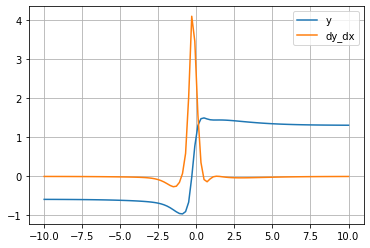

In [54]:
# Let's create an MLP with random weights and compute the gradients wrt the inputs
batch_size = 100
x = np.linspace(-10, 10, batch_size)
mlp_batch = MLPBatch(1, 10, 20, 1)
y = mlp_batch.forward(x.reshape((batch_size, 1))).flatten()

dy_dx = mlp_batch.backward(np.ones((batch_size, 1))).flatten()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, dy_dx)
ax.grid(True)
ax.legend(['y', 'dy_dx'])

You can visually inspect whether the computations of the derivative seem correct.

More importantly, we can compute the gradient of a loss wrt the parameters of the MLP. The gradients can be used to update the parameters using gradient descent.

## 3. Training MLP network with backpropagation

Now let us use our code to train an MLP network.

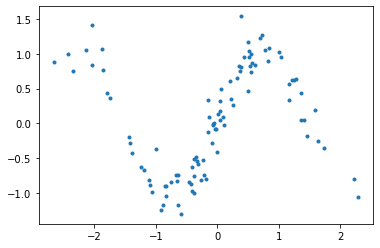

In [55]:
# Let us generate toy data
np.random.seed(2)
x = np.random.randn(100, 1)
x = np.sort(x, axis=0)
targets = np.sin(x * 2 * np.pi / 3)
targets = targets + 0.2 * np.random.randn(*targets.shape)

# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')

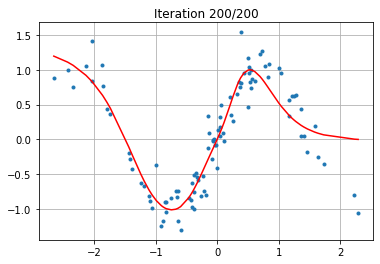

In [57]:
# And train an MLP network using gradient descent
from IPython import display

if not skip_training:  # The trained MLP is not tested
    mlp = MLPBatch(1, 10, 10, 1)  # Create MLP network
    loss = MSELoss()  # Create loss

    fig, ax = plt.subplots(1)
    ax.plot(x, targets, '.')
    learning_rate = 0.15
    n_epochs = 1 if skip_training else 200
    for i in range(n_epochs):
        # Forward computations
        y = mlp.forward(x)
        c = loss.forward(y, targets)

        # Backward computations
        dy = loss.backward()
        dx = mlp.backward(dy)

        # Gradient descent update
        learning_rate *= 0.99  # Learning rate annealing
        for module in mlp.__dict__.values():
            if hasattr(module, 'W'):
                module.W = module.W - module.grad_W * learning_rate
                module.b = module.b - module.grad_b * learning_rate

        ax.clear()
        ax.plot(x, targets, '.')
        ax.plot(x, y, 'r-')
        ax.grid(True)
        ax.set_title('Iteration %d/%d' % (i+1, n_epochs))
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.005)
    display.clear_output(wait=True)

If you implement the MLP correctly, you will see that the learned function fits the training data.

<div class="alert alert-block alert-info">
<b>Conclusions</b>
</div>

Now you have implemented backpropagation and trained an MLP network using gradient descent.

PyTorch makes it easier to create neural networks with different architectures and optimize its parameters using (variants of) gradient descent:
* It contains multiple building blocks with forward and backward computations implemented.
* It implements optimization methods that work well for neural networks.
* Computations can be performed either on GPU or CPU using the same code.